In [1]:
from generate_mdps import generate_datsets
from dataset import MDPDataset, AllNodeFeatures, InMemoryMDPDataset, TransitionsOnEdge
from experiment import Experiment
from MDP_helpers import calculate_gap, multiclass_recall_score

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import numpy as np

import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import GCN, GAT
from torch.utils.data import random_split
from collections import defaultdict
from sklearn.metrics import recall_score, accuracy_score

from time import time
from tqdm import tqdm

/home/james/virtual_envs/csiro_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.manual_seed(12345)
np.random.seed(12345)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device='cpu'
print(device)

cuda


In [5]:
hparam_file = "hparams"
experiment_name = "GAT_weighted_edge"

os.mkdir(f"Results/{experiment_name}") if not os.path.isdir(f"Results/{experiment_name}") else ...

Ellipsis

In [6]:
N_datasets = 100

N_sites = 6
N_species = 20
K = 8

N_epochs = 3000
N_epochs_H = 1000
lr = 0.001
lr_H = 0.01
edge_attributes = True

N_states = 3**N_sites
print(f"N_states: {N_states}")
dataset_folder = f"Reserve_MDP_{N_states}_{K}"
generate_datsets(N_sites, N_species, K, N_datasets, remove_previous=False, folder=dataset_folder)

N_states: 729


'Data already exists'

In [7]:
dataset = InMemoryMDPDataset(f"datasets/{dataset_folder}", pre_transform=TransitionsOnEdge())

/home/james/Repo/MDP-State-Abstraction-CSIRO/Approach_new/sensitive_states/dataset.py:125: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  edge_features = torch.Tensor([P[:, i[0], i[1]].numpy() for i in edges])


In [8]:
torch.all(dataset[0].R == dataset[5].R)

tensor(False)

In [9]:
train_ratio = 0.8
test_ratio = 0.2

train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

h_param_size = int(train_ratio*train_size)
val_size = train_size - h_param_size

train_set, test_set = random_split(dataset, [train_size, test_size])
hparam_train_set, hparam_val_set = random_split(train_set, [h_param_size, val_size])

train_data = DataLoader(train_set, batch_size=1, shuffle=True)
test_data = DataLoader(test_set, batch_size=1, shuffle=True)
hparam_train_data = DataLoader(hparam_train_set, batch_size=1, shuffle=True)
hparam_val_data = DataLoader(hparam_val_set, batch_size=1, shuffle=True)

In [10]:
def objective(trial):
    hidden_channels = trial.suggest_int("hidden_channels", 100, 250)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0, 0.05)
    weight_decay = trial.suggest_float("weight_decay", 1e-3, 0.05)


    model = GAT(
        in_channels=dataset[0].x.shape[1], 
        out_channels=K, 
        hidden_channels=hidden_channels, 
        num_layers=num_layers, 
        dropout=dropout
    ).to(device)


    optimizer = torch.optim.Adam(model.parameters(), lr=lr_H, weight_decay=weight_decay)

    model.train()
    for epoch in range(N_epochs_H):
        optimizer.zero_grad()     
        loss = 0

        for data in hparam_train_data:
            if edge_attributes:
                pred = model(
                    x = data.x.to(device), 
                    edge_index=data.edges.to(device), 
                    edge_attr=data.edge_features.to(device)
                )
            else:
                pred = model(
                    x = data.x.to(device), 
                    edge_index=data.edges.to(device), 
                )  
            weight = torch.bincount(data.k_labels)
            weight = weight/weight.sum()
            loss += F.cross_entropy(pred, data.k_labels.to(device), weight=weight.to(device))

        loss /= len(train_data) 
        loss.backward()
        optimizer.step()

        test_loss = 0
        model.eval()
        for data in hparam_val_data:
            if edge_attributes:
                pred = model(
                    x = data.x.to(device), 
                    edge_index=data.edges.to(device), 
                    edge_attr=data.edge_features.to(device)
                )
            else:
                pred = model(
                    x = data.x.to(device), 
                    edge_index=data.edges.to(device), 
                )  
            weight = torch.bincount(data.k_labels)
            weight = weight/weight.sum()
            test_loss += F.cross_entropy(pred, data.k_labels.to(device), weight=weight.to(device))
        test_loss /= len(hparam_val_data)
    return test_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

best_params = study.best_params

print(study.best_value)
print(best_params)

[I 2023-12-14 06:12:45,863] A new study created in memory with name: no-name-ba57be44-1ba4-4993-9ba9-0c05cd712916


[I 2023-12-14 06:16:57,020] Trial 0 finished with value: 0.9600316882133484 and parameters: {'hidden_channels': 164, 'num_layers': 3, 'dropout': 0.02376585295635486, 'weight_decay': 0.002274421032648851}. Best is trial 0 with value: 0.9600316882133484.
[I 2023-12-14 06:19:08,467] Trial 1 finished with value: 1.8023555278778076 and parameters: {'hidden_channels': 221, 'num_layers': 1, 'dropout': 0.04566653704456792, 'weight_decay': 0.03313935164591242}. Best is trial 0 with value: 0.9600316882133484.
[I 2023-12-14 06:23:41,569] Trial 2 finished with value: 0.9987708926200867 and parameters: {'hidden_channels': 237, 'num_layers': 3, 'dropout': 0.04997286197474489, 'weight_decay': 0.004092464859227803}. Best is trial 0 with value: 0.9600316882133484.
[I 2023-12-14 06:26:59,957] Trial 3 finished with value: 1.5023431777954102 and parameters: {'hidden_channels': 225, 'num_layers': 2, 'dropout': 0.0054931754922274145, 'weight_decay': 0.010554269302460208}. Best is trial 0 with value: 0.96003

0.7101234793663025
{'hidden_channels': 249, 'num_layers': 3, 'dropout': 0.04908228290945542, 'weight_decay': 0.0011251859096131807}


In [11]:
# trials = [i for i in map(lambda x: dict([("loss", x.values[0]), ("recall", x.values[1]),*(x.params).items()]), study.get_trials())]
# trials = pd.DataFrame(trials)
# trials = trials.sort_values(by='recall', ascending=False)

trials = [i for i in map(lambda x: dict([("score", x.values[0]),*(x.params).items()]), study.get_trials())]
trials = pd.DataFrame(trials)
trials = trials.sort_values(by='score', ascending=False)

experiment = Experiment(savefile=f"Results/{experiment_name}/hparams")
for i in trials.index:
    trials.loc[i].to_dict()
    experiment.save(trials.loc[i].to_dict())

In [12]:
pd.DataFrame(experiment.load()).sort_values(by="score", ascending=True).head()

,score,hidden_channels,num_layers,dropout,weight_decay
29,0.710123,249.0,3.0,0.049082,0.001125
28,0.737330,120.0,3.0,0.047526,0.001454
27,0.749871,161.0,3.0,0.042554,0.001014
26,0.767374,150.0,3.0,0.044162,0.001383
25,0.871606,150.0,3.0,0.045378,0.001202


In [13]:
all_results = defaultdict(lambda : defaultdict(list))
trial_name = "Trial"
trial_num = 0

hidden_channels = int(best_params['hidden_channels'])
num_layers = int(best_params['num_layers'])
dropout = best_params['dropout']
weight_decay = best_params['weight_decay']

model = GAT(
    in_channels=dataset[0].x.shape[1], 
    out_channels=K, 
    hidden_channels=hidden_channels, 
    num_layers=num_layers, 
    dropout=dropout
).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

epochs = tqdm(range(N_epochs))
for epoch in epochs:
    model.train()
    optimizer.zero_grad()     

    loss = 0
    for data in train_data:
        if edge_attributes:
            pred = model(
                x = data.x.to(device), 
                edge_index=data.edges.to(device), 
                edge_attr=data.edge_features.to(device)
            )
        else:
            pred = model(
                x = data.x.to(device), 
                edge_index=data.edges.to(device), 
            )  
        weight = torch.bincount(data.k_labels)
        weight = weight/weight.sum()
        loss += F.cross_entropy(pred, data.k_labels.to(device), weight=weight.to(device))

    loss /= len(train_data) 
    loss.backward()
    optimizer.step()

    all_results[trial_name]['training_loss'].append(loss.to('cpu').detach().float())


    model.eval()
    test_loss = 0
    avg_gap = 0
    avg_error = 0
    avg_recall = 0
    avg_acc = 0
    for data in test_data:
        if edge_attributes:
            pred = model(
                x = data.x.to(device), 
                edge_index=data.edges.to(device), 
                edge_attr=data.edge_features.to(device)
            )
        else:
            pred = model(
                x = data.x.to(device), 
                edge_index=data.edges.to(device), 
            )  
        pred_k = F.softmax(pred, dim=1).argmax(axis=1)
        weight = torch.bincount(data.k_labels)
        weight = weight/weight.sum()
        test_loss += F.cross_entropy(pred, data.k_labels.to(device), weight=weight.to(device))
        gap, error = calculate_gap(data.P, data.R, data.V, pred_k, K, device='cpu')
        avg_gap += gap
        avg_error += error
        avg_recall += recall_score(data.k_labels, pred_k.to('cpu'), average="macro")
        avg_acc += accuracy_score(data.k_labels, pred_k.to('cpu'))


    test_loss /= len(test_data)
    avg_gap /= len(test_data)
    avg_error /= len(test_data)
    avg_recall /= len(test_data)
    avg_acc /= len(test_data)

    all_results[trial_name]['test_loss'].append(test_loss.to('cpu').detach().float())
    all_results[trial_name]['test_gap'].append(avg_gap)
    all_results[trial_name]['test_error'].append(avg_error)
    all_results[trial_name]['test_recall'].append(avg_recall)
    all_results[trial_name]['test_accuracy'].append(avg_acc)

    epochs.set_description(f"Trial {trial_num}, Epoch {epoch+1}/{N_epochs}, Loss {test_loss:.4f}, Gap {avg_gap:.4f}, Recall {avg_recall:.4f}, Accuracy {avg_acc:.4f}")

  0%|          | 0/3000 [00:00<?, ?it/s]/home/james/Repo/MDP-State-Abstraction-CSIRO/Approach_new/sensitive_states/MDP_helpers.py:32: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  Q[:, a] = R[:, a].T + gamma*T[a, :, :]@V
Trial 0, Epoch 5/3000, Loss 1.9629, Gap 1.3654, Recall 0.1320, Accuracy 0.1816:   0%|          | 5/3000 [00:05<54:57,  1.10s/it]  

Trial 0, Epoch 3000/3000, Loss 0.7261, Gap 0.1827, Recall 0.5699, Accuracy 0.7013: 100%|██████████| 3000/3000 [1:08:50<00:00,  1.38s/it]


In [14]:
# all_results.pop(trial_name);    

In [15]:
processed = {}
for key in all_results["trial_0"].keys():
    df = pd.DataFrame({trial_id:all_results[trial_id][key] for trial_id in all_results.keys()}).astype(float)
    df.to_csv(f"Results/{experiment_name}/{key}.csv")
    processed[key] = df

Generating plots


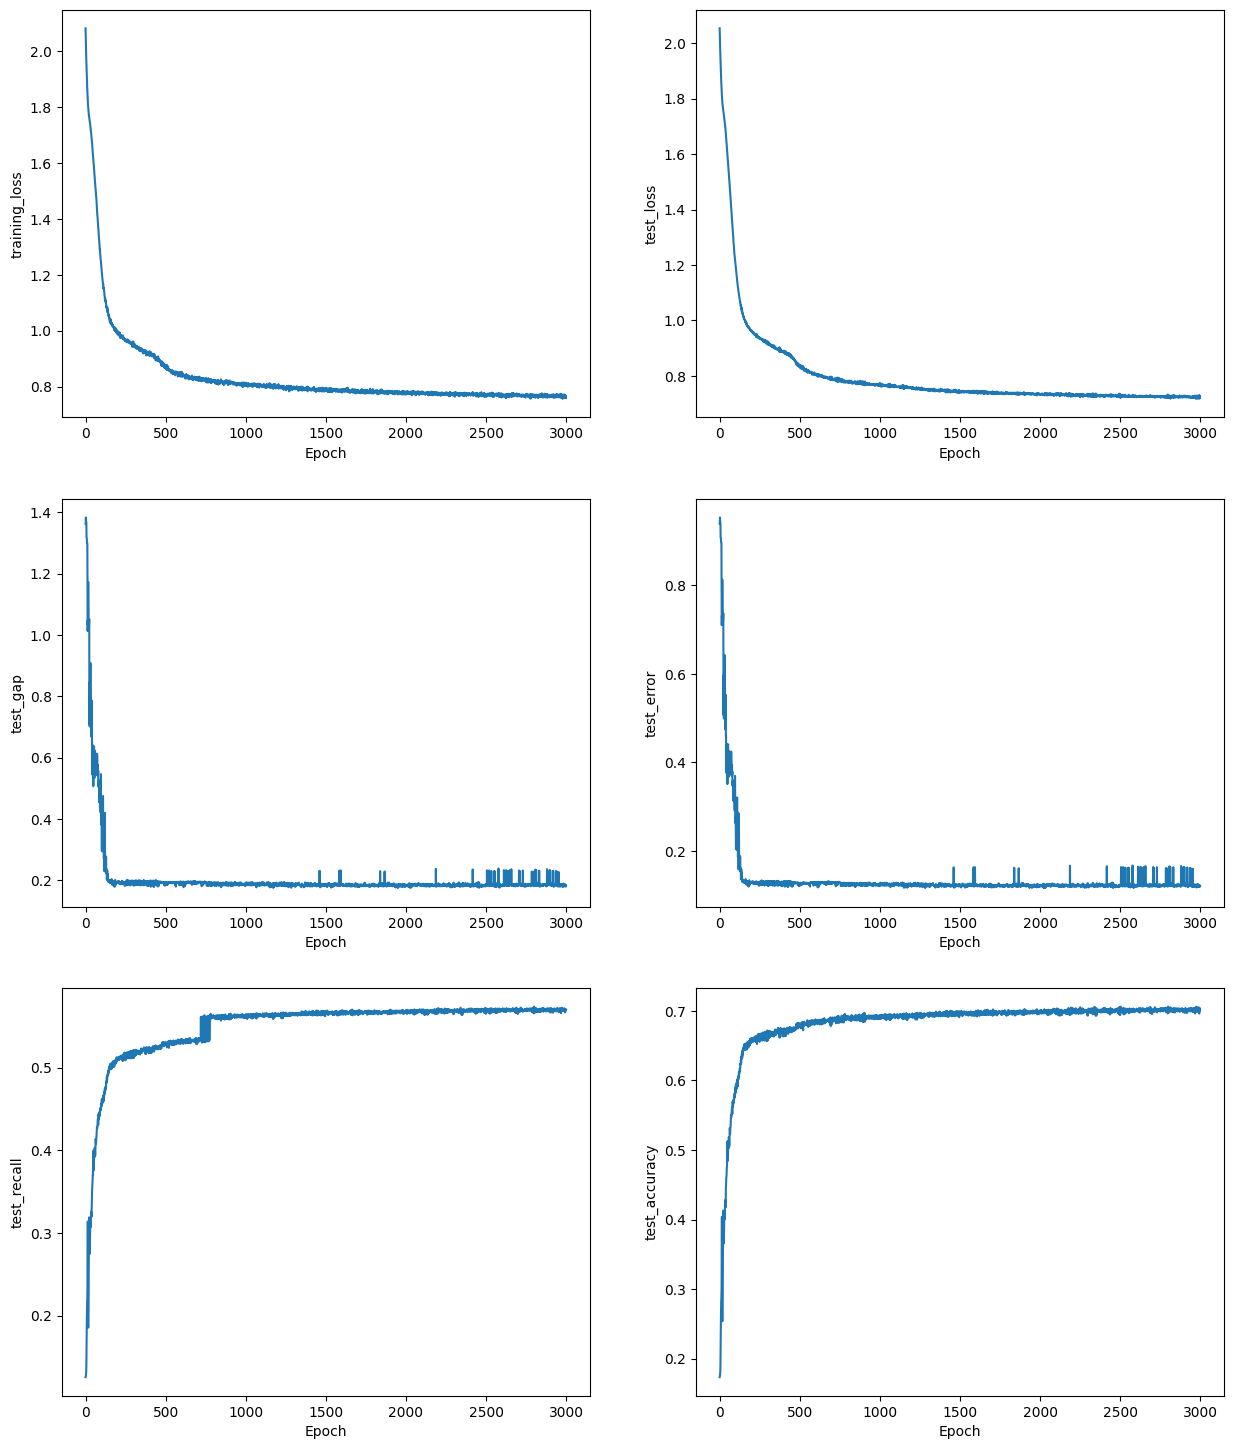

In [33]:
processed = {}
for key in all_results["Trial"].keys():
    df = pd.DataFrame({trial_id:all_results[trial_id][key] for trial_id in all_results.keys()}).astype(float)
    # df.to_csv(f"Results/{experiment_name}/{filename}/{key}.csv")
    processed[key] = df

print("Generating plots")
n_plots = len(all_results["Trial"].keys())
n_cols = 2
n_rows = int((n_plots + n_plots%2)/2)

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 6*n_rows))

count = 0
for key in all_results["Trial"].keys():
    col = count %2
    row = count //2 
    count += 1

    df_long = processed[key].stack()
    df_long.index = df_long.index.to_flat_index().map(lambda x: x[0])
    sns.lineplot(df_long, errorbar='ci', ax=ax[row, col])
    ax[row, col].set_ylabel(key)
    ax[row, col].set_xlabel("Epoch")

plt.savefig(f"Results/{experiment_name}/plots.png")